# Environnement

In [ ]:
#import all the necessary packages
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
import sklearn
import shutil
from google.colab import drive
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Kidneyppyng/"
os.chdir(path)

# Visualisation

In [ ]:
#define the image path and load the data
image_path = "DATA/cases/case_00002/case_00002_imaging.nii.gz"
image_obj = nib.load(image_path)

#extract data as numpy ndarray
image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [ ]:
#shape format : (z, y, x) corresponding to (axial, coronal, sagittal) plane
image_data.shape

(261, 512, 512)

📌 [Understanding coordinate systems and DICOM for deep learning medical image analysis](https://theaisummer.com/medical-image-coordinates/)

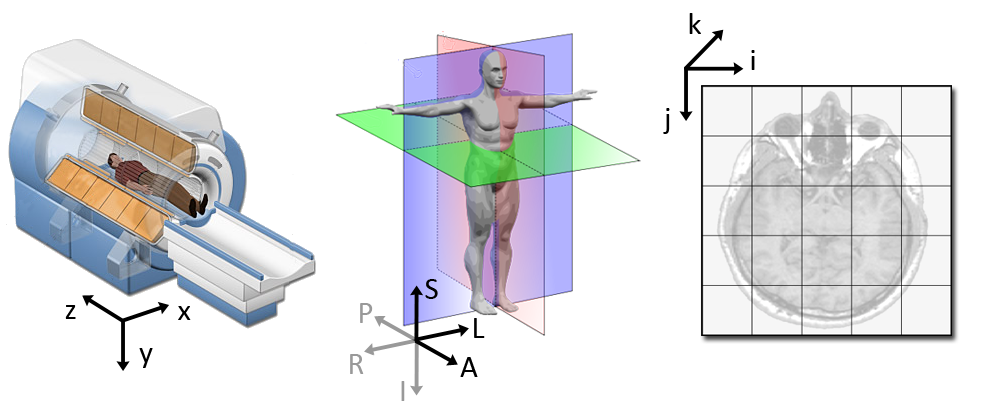

In [ ]:
#define a function to visualize the raw data

def explore_3dimage(layer):
    plt.figure(figsize=(16, 9))
    plt.imshow(image_data[layer, : , :], cmap='gray');
    plt.title('Raw Data', fontsize=20, pad=30)
    plt.axis('off')
    plt.colorbar()
    return layer

#run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image_data.shape[0] - 1));

interactive(children=(IntSlider(value=130, description='layer', max=260), Output()), _dom_classes=('widget-int…

In [ ]:
#same for the segmentation
label_path = "DATA/cases/case_00002/case_00002_aggregated_MAJ_seg.nii.gz"
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

In [ ]:
#extract data labels
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [ ]:
label_array.shape

(261, 512, 512)

In [ ]:
#define a function to visualize the segmentation

def explore_3dimage(layer):
    plt.figure(figsize=(16, 9))
    data = label_array[layer, :, :]

    #get discrete colormap
    cmap = plt.get_cmap('gray', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    im = plt.imshow(data, cmap=cmap, vmin = np.min(data)-.5, vmax = np.max(data)+.5);
    #tell the colorbar to tick at integers
    cax = plt.colorbar(im, ticks=np.arange(np.min(data), np.max(data)+1))
    
    plt.title('Ground Truth', fontsize=20, pad=30)
    plt.axis('off')
    return layer

#run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, label_array.shape[0] - 1));

interactive(children=(IntSlider(value=130, description='layer', max=260), Output()), _dom_classes=('widget-int…

In [ ]:
#extract the shape of the labels data
depth, height, width = label_array.shape

print(f"Dimensions of labels data array height : width: {width}, height: {height}, depth: {depth}")
print(f'With the unique values: {np.unique(label_array)}')
print("""
Corresponding to the following label categories : 
0 : background 
1 : kidney
2 : tumor 
3 : cyst 
""")

Dimensions of labels data array height : width: 512, height: 512, depth: 261
With the unique values: [0. 1. 2. 3.]

Corresponding to the following label categories : 
0 : background 
1 : kidney
2 : tumor 
3 : cyst 



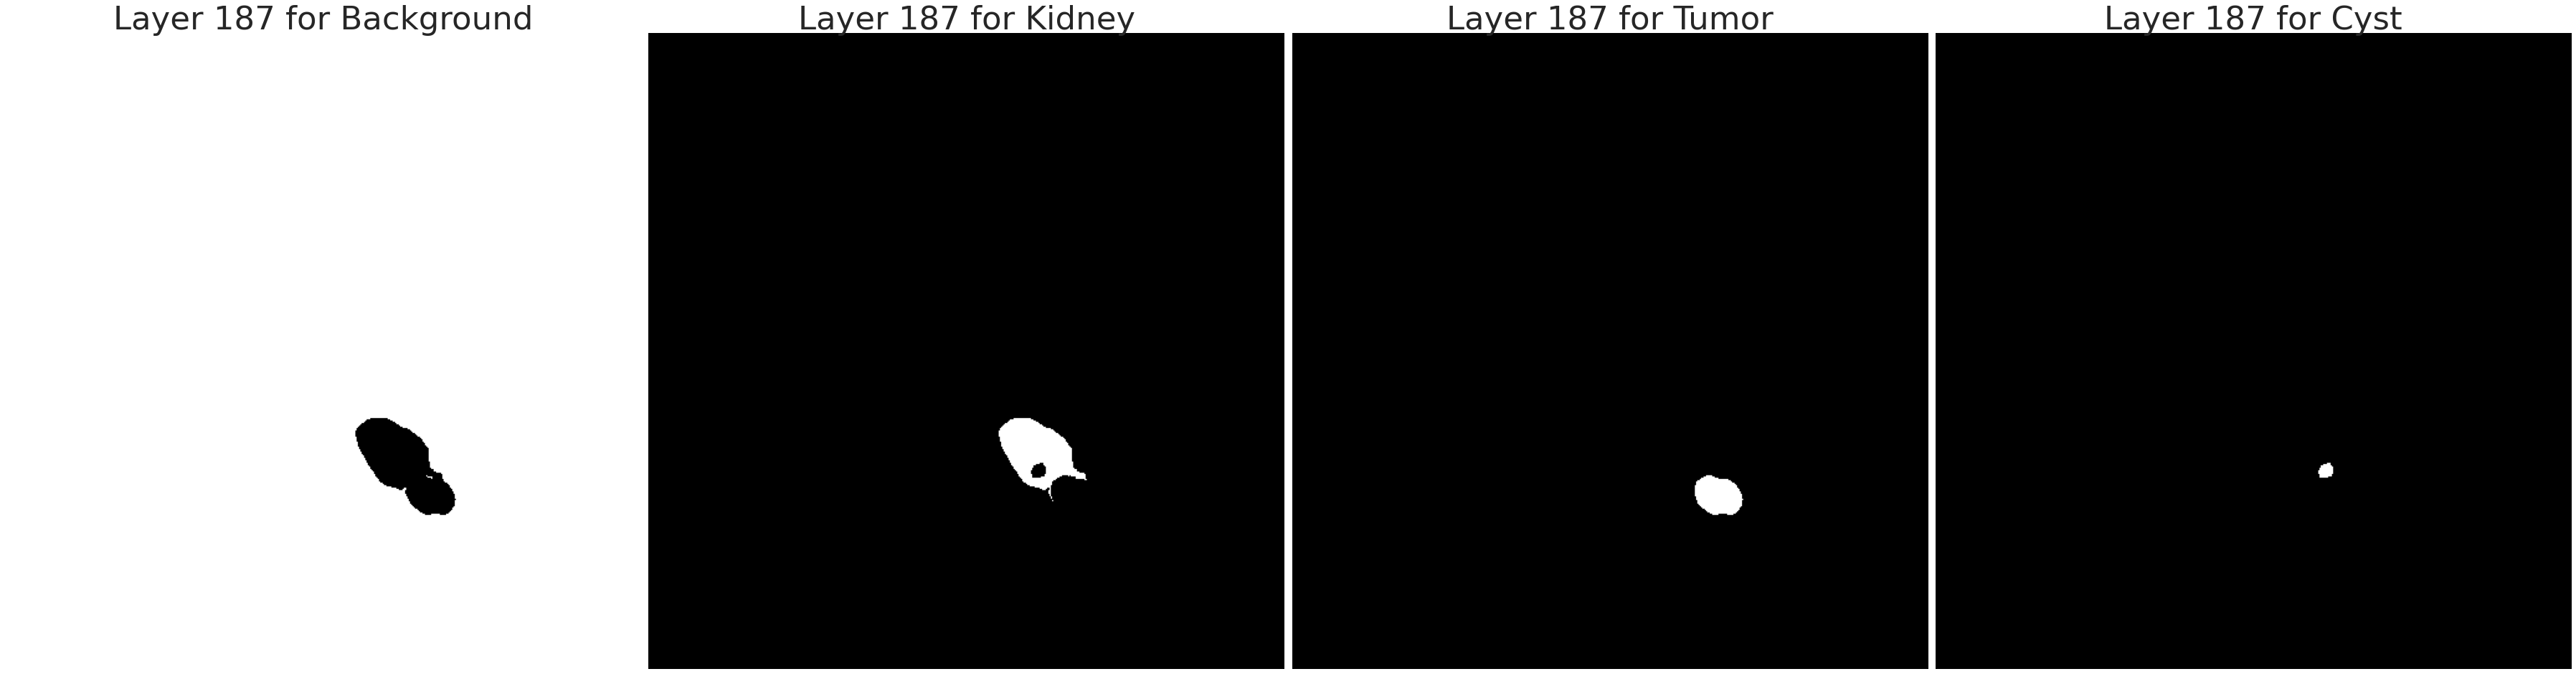

In [ ]:
#define a single layer for plotting
layer = 187

#define a dictionary of class labels
classes_dict = {
    'Background': 0.,
    'Kidney': 1.,
    'Tumor': 2.,
    'Cyst': 3.,
}

#set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[layer,:,:]
    mask = np.where(img == classes_dict[img_label_str], 512, 0)
    ax[i].imshow(mask, cmap='gray')
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

In [ ]:
#create button values
select_class = ToggleButtons(
    options=['Background','Kidney', 'Tumor', 'Cyst'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    )

#create layer slider
select_layer = IntSlider(min=0, max=depth, description='Select Layer', continuous_update=False)

    
#define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[layer,:,:] == img_label, 512, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

#use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Background', '…

# Constitution du dossier all_cases

In [ ]:
"""
Détails des étapes suivantes : 

Problème : avoir un dossier où toutes les images originales et segmentées sont au même endroit afin d'établir un 
training et test set
Solution : coder ce dossier 

Problème : dans chaque dossier patient, les images originales et segmentées s'appellent de la même façon :
'imaging.nii.gz' et 'aggregated_MAJ_seg.nii.gz'
Solution : renommer ces fichiers en y incorporant l'ID du patient

Actions réalisées : 
    - Une fois ceci fait, création du dossier all_cases contenant les dossiers imaging et aggregated_MAJ
    - Copie de toutes les images et segmentation dans leur dossier respectifs
"""

"\nDétails des étapes suivantes : \n\nProblème : avoir un dossier où toutes les images originales et segmentées sont au même endroit afin d'établir un \ntraining et test set\nSolution : coder ce dossier \n\nProblème : dans chaque dossier patient, les images originales et segmentées s'appellent de la même façon :\n'imaging.nii.gz' et 'aggregated_MAJ_seg.nii.gz'\nSolution : renommer ces fichiers en y incorporant l'ID du patient\n\nActions réalisées : \n    - Une fois ceci fait, création du dossier all_cases contenant les dossiers imaging et aggregated_MAJ\n    - Copie de toutes les images et segmentation dans leur dossier respectifs\n"

In [ ]:
# #change directory
# os.chdir('/content/drive/MyDrive/Kidneyppyng/DATA/cases')

# #create folders
# os.mkdir('all_cases')

# os.chdir('/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases')

# os.mkdir('imaging')
# os.mkdir('aggregated_MAJ')

In [ ]:
# #rename imaging files 
# for case in range (300):
#     try  : 

#         path = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/case_" + str(case).zfill(5) + "/imaging.nii.gz"
#         os.rename(path, f"/content/drive/MyDrive/Kidneyppyng/DATA/cases/case_" + str(case).zfill(5) + "/case_" + str(case).zfill(5) + "_imaging.nii.gz")
    
#     except :
#         pass

In [ ]:
# for imaging in range (300):
#     # Source path
#     source = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/case_" + str(imaging).zfill(5) + "/case_" + str(imaging).zfill(5) + "_imaging.nii.gz" 
#     print(source)

#     # Destination path
#     destination = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/imaging" + "/case_" + str(imaging).zfill(5) + "_imaging.nii.gz" 
#     print(destination)

#     # Copy the content of source to destination
#     try :
#         shutil.copyfile(source, destination)
#         print("File copied successfully.")
    
#     # If source and destination are same
#     except shutil.SameFileError :
#         print("Source and destination represents the same file.")

#     # If destination is a directory.
#     except IsADirectoryError :
#         print("Destination is a directory.")
    
#     # If there is any permission issue
#     except PermissionError :
#         print("Permission denied.")

#     # For other errors
#     except :
#         print("Error occurred while copying file.")

In [ ]:
# #rename aggregated files 
# for aggregated in range (300):
#     try  : 

#         path = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/case_" + str(aggregated).zfill(5) + "/aggregated_MAJ_seg.nii.gz"
#         os.rename(path, f"/content/drive/MyDrive/Kidneyppyng/DATA/cases/case_" + str(aggregated).zfill(5) + "/case_" + str(aggregated).zfill(5) + "_aggregated_MAJ_seg.nii.gz")
    
#     except :
#         pass
        
        
# for aggregated in range (300):
#     # Source path
#     source = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/case_" + str(aggregated).zfill(5) + "/case_" + str(aggregated).zfill(5) + "_aggregated_MAJ_seg.nii.gz" 
#     print(source)

#     # Destination path
#     destination = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/aggregated_MAJ" + "/case_" + str(aggregated).zfill(5) + "_aggregated_MAJ_seg.nii.gz" 
#     print(destination)

#     # Copy the content of source to destination
#     try :
#         shutil.copyfile(source, destination)
#         print("File copied successfully.")
    
#     # If source and destination are same
#     except shutil.SameFileError :
#         print("Source and destination represents the same file.")

#     # If destination is a directory.
#     except IsADirectoryError :
#         print("Destination is a directory.")
    
#     # If there is any permission issue
#     except PermissionError :
#         print("Permission denied.")

#     # For other errors
#     except :
#         print("Error occurred while copying file.")

# Création du Dataframe 

In [ ]:
# #imaging path
# imaging_path = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/imaging/"
# imaging_list = []

# for root , dirs, file in os.walk(imaging_path) :
#      for name in file :
#           imaging_list.append(os.path.join(root, name))

# df_imaging = pd.DataFrame(list(sorted(imaging_list)))
# df_imaging.to_csv("/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/imaging/df_imaging.csv", index = False, encoding = 'utf-8-sig')

In [ ]:
# #segmentation path
# segmentation_path = "/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/aggregated_MAJ"
# segmentation_list = []

# for root , dirs, file in os.walk(segmentation_path) :
#      for name in file :
#           segmentation_list.append(os.path.join(root, name))

# df_segmentation = pd.DataFrame(list(sorted(segmentation_list)))
# df_segmentation.to_csv("/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/aggregated_MAJ/df_segmentation.csv", index = False, encoding = 'utf-8-sig')

In [ ]:
# #join df
# df = pd.DataFrame(list(zip(sorted(imaging_list), sorted(segmentation_list))), columns = ['imaging_path', 'segmentation_path'])

# df.to_csv("/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/df.csv", index = False, encoding = 'utf-8-sig')

# df

In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/df.csv")
#df.head()

# Train, test  & validation split

In [ ]:
# def train_validation_test_split(initial_dataset, validation_test_size, test_size) :
#   """
#   Function to separate the dataset into 3 subsets : training, validation and test. 

#   Parameters
#   ----------
#   initial_dataset : DataFrame
#   The pandas DataFrame that contains the data.

#   validation_test_size : FLOAT
#   The proportion of the subset that will be split into validation and test subsets.

#   test_size : FLOAT
#   The proportion of the test subset.

#   Return
#   ------
#   The training, validation and test subsets.
#   """

#   #division of the initial dataset into train and validation_test
#   train, validation_test = train_test_split(initial_dataset, test_size=validation_test_size, random_state=True)
  
#   train.to_csv('/content/drive/MyDrive/Kidneyppyng/DATA/train.csv', index=False)

#   #division of the validation_test set into validation and test
#   validation, test = train_test_split(validation_test, test_size=test_size, random_state=True, shuffle=True, stratify=None)
  
#   validation.to_csv('/content/drive/MyDrive/Kidneyppyng/DATA/validation.csv', index=False)
#   test.to_csv('/content/drive/MyDrive/Kidneyppyng/DATA/test.csv', index=False)

#   return train, validation, test

In [ ]:
# #division of the dataset into 3 subsets
# train_set, validation_set, test_set = train_validation_test_split(df, 0.3, 0.33)

# #checking the size of the subsets
# print("Nombre de séries pour l'apprentissage :", len(train_set))
# print("Nombre de séries pour la validation :", len(validation_set))
# print("Nombre de séries pour le test :", len(test_set))

In [ ]:
#import csv files
df_train = pd.read_csv('/content/drive/MyDrive/Kidneyppyng/DATA/train.csv')

df_test = pd.read_csv('/content/drive/MyDrive/Kidneyppyng/DATA/test.csv')

df_validation = pd.read_csv('/content/drive/MyDrive/Kidneyppyng/DATA/validation.csv')

# Generator

📌

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
df_train = df_train.drop(df_train.index[134]).reset_index(drop=True)

In [ ]:
train_directories = df_train['imaging_path']
validation_directories = df_validation['imaging_path']
test_directories = df_test['imaging_path']

In [ ]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:-15])
    return x

train_ids = pathListIntoIds(train_directories)
validation_ids = pathListIntoIds(validation_directories); 
test_ids = pathListIntoIds(test_directories)

In [ ]:
IMAGING_DATASET_PATH = '/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/imaging'

SEGMENTATION_DATASET_PATH = '/content/drive/MyDrive/Kidneyppyng/DATA/cases/all_cases/aggregated_MAJ'

In [ ]:
#PRBLM AVEC CA 
#3D ENFAITE

VOLUME_SLICES = 1

VOLUME_START_AT = 5

#Charger autant d'img que le batch size ? 

In [ ]:
import tensorflow.keras as keras
import keras.backend as K
import cv2

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(512, 512), batch_size = 4, n_channels = 1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    
    def __data_generation(self, Batch_ids):
      #POUR TRACKER LES ERREURS PRENDRE JUSTE CETTE DEF ET L'ADAPTER A UN CAS EN PARTICULIER POUR VOIR OU CA BUG
      #METTRE DES PRINTS PARTOUT
      #POUR GENERER PRROCHAIN BATCH NEXT(dataset)
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, VOLUME_SLICES, *self.dim, 1))
        y = np.zeros((self.batch_size, VOLUME_SLICES, 512, 512))
        #Y = np.zeros((self.batch_size, VOLUME_SLICES, *self.dim, 1))

        # Generate data
        for i, path in enumerate(Batch_ids):

            data_path = os.path.join(IMAGING_DATASET_PATH, f'{path}_imaging.nii.gz')
            imaging = nib.load(data_path).get_fdata()    
            
            data_path = os.path.join(SEGMENTATION_DATASET_PATH, f'{path}_aggregated_MAJ_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

        
            for j in range(VOLUME_SLICES):
                 X[i, j, :, :, 0] = cv2.resize(imaging[j+VOLUME_START_AT,:,:], (IMG_SIZE, IMG_SIZE)); #0 à la place de 1 ?
                 y[i, j, :, :] = seg[j + VOLUME_START_AT,:,:];
                    
        # Generate masks
        #y[y==4] = 3;
        #mask = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));

        return np.squeeze(X/np.max(X), 1), np.squeeze(y, 1)

In [ ]:
training_generator = DataGenerator(train_ids)
test_generator = DataGenerator(test_ids)
valid_generator = DataGenerator(validation_ids)

In [ ]:
#X_t, y_t = next(iter(training_generator))

#print(X_t.shape)

#y_t.shape

# UNet

In [ ]:
IMG_SIZE=512

In [ ]:
#POUR LE PROBLEME DU Z PRENDRE LE Z MINIMUM QUE L'ON RETROUVE DANS LE DATASET ET PARTIR DU CA (CF JSON)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras as keras

# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 1))

model = build_unet(input_layer, 'he_normal', 0.2)
#model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy', keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_kidney, dice_coef_tumor ,dice_coef_cyst])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#TO REVIEW WITH MORE & RIGHT PARAMETERS
model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam')

# Problems : some images have different shape of (512, 512) 

📌

This comment code below return case_00160 : (252, 512, 796)

Action :

Add this line : df_train.drop(df_train.index[134], inplace=True) to the beggining of the Generator Section

In [ ]:
# from tqdm import tqdm

# path = "DATA/cases/all_cases/imaging/"

# for case in tqdm(os.listdir(path)) : 

#   image_obj = nib.load(os.path.join(path, case))
#   image_data = image_obj.get_fdata()
#   if image_data.shape != (image_data.shape[-3], 512, 512) : 
#     print(case, ":", image_data.shape)
#   else : 
#     pass

# Fit

In [ ]:
model.fit(training_generator)

52/52 [==============================] - 1201s 23s/step - loss: 0.0906


In [ ]:
prediction = model.predict(test_generator)